In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing
from skimage.io import imsave, imread

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm

import os

import plotly.graph_objs as go

import platform

### Read image

Read image as greyscale and color in parallel

In [2]:
image_filename = '/Users/carolinemccue/Desktop/MG63/r01c02f26p03-ch2sk1fk1fl1.tiff'

if os.path.isdir(image_filename):
    img_list = [os.path.join(image_filename,f) for f in os.listdir(image_filename) if f.endswith('.jpg')]
elif os.path.isfile(image_filename):
    img_list = [image_filename]

for image_file in img_list:
        image = cv2.imread(image_file, 0)

In [3]:
out_directory = "MG63_5"
if not os.path.exists(out_directory):
    os.mkdir(out_directory)

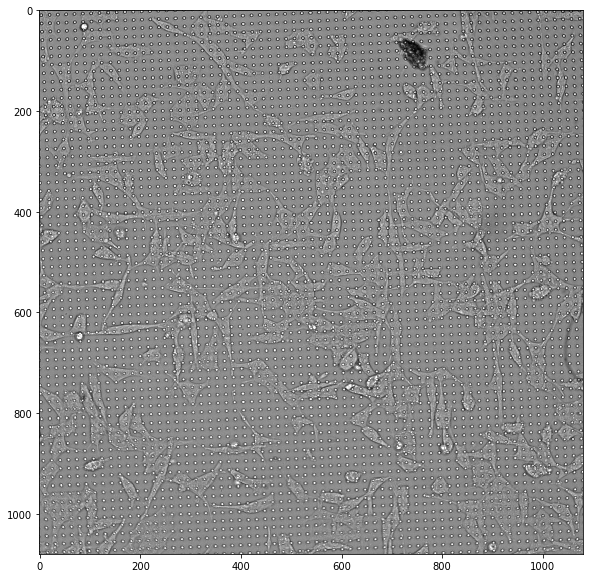

In [4]:
#image_file = cv2.imread('/Users/carolinemccue/Desktop/MG63/r01c02f26p03-ch2sk1fk1fl1.tiff',0)
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest')

plt.show()

### convert to uint (for some skimage methods)

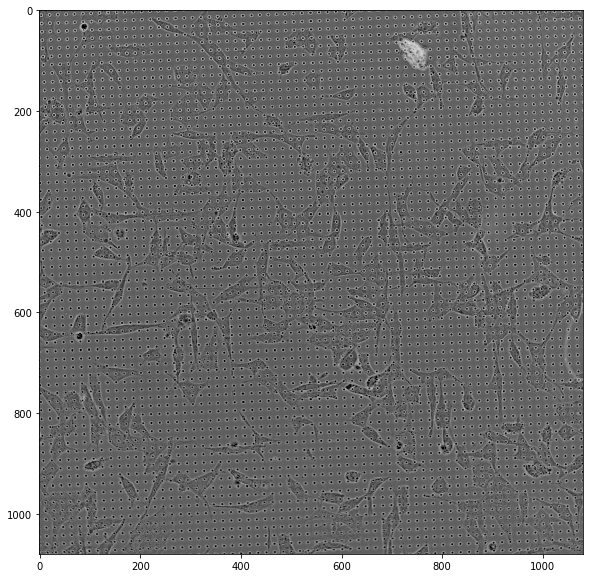

In [5]:
image = np.invert(image)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')
plt.show()

### Increase contrast

Adaptive equalization can deal with some non-uniformity in the original image

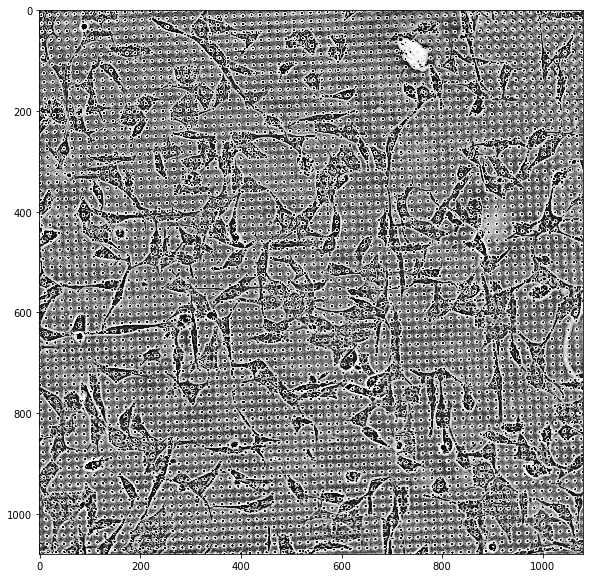

In [6]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(10,10))
img_adapteq = clahe.apply(image)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

### Threshold

Otsu threshold was found to work best in this type of image (see SegmentationDropletsInCapillary).

Minimum threshold: 65.0
Min intensity: 0
Max intensity: 255


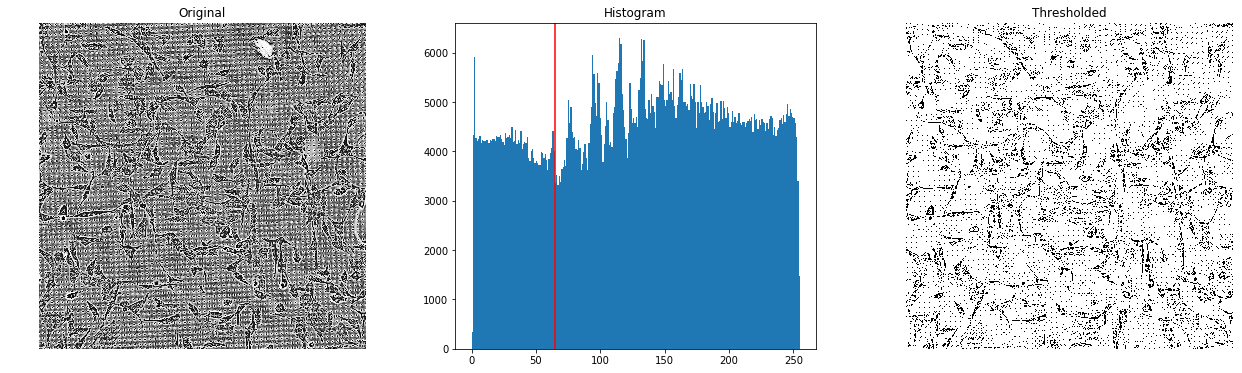

In [7]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(3,3),0)
retVal, binary = cv2.threshold(blur,65,255,cv2.THRESH_BINARY)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

### Perform Watershed segmentation

- Close to remove artifacts from contrast increase and thresholding
- Detect sure foreground and background from thresholding and distance transform
- Run the watershed algorithm to segment
- Label segmented regions

#### Closing and removing small dark spots from crystal borders

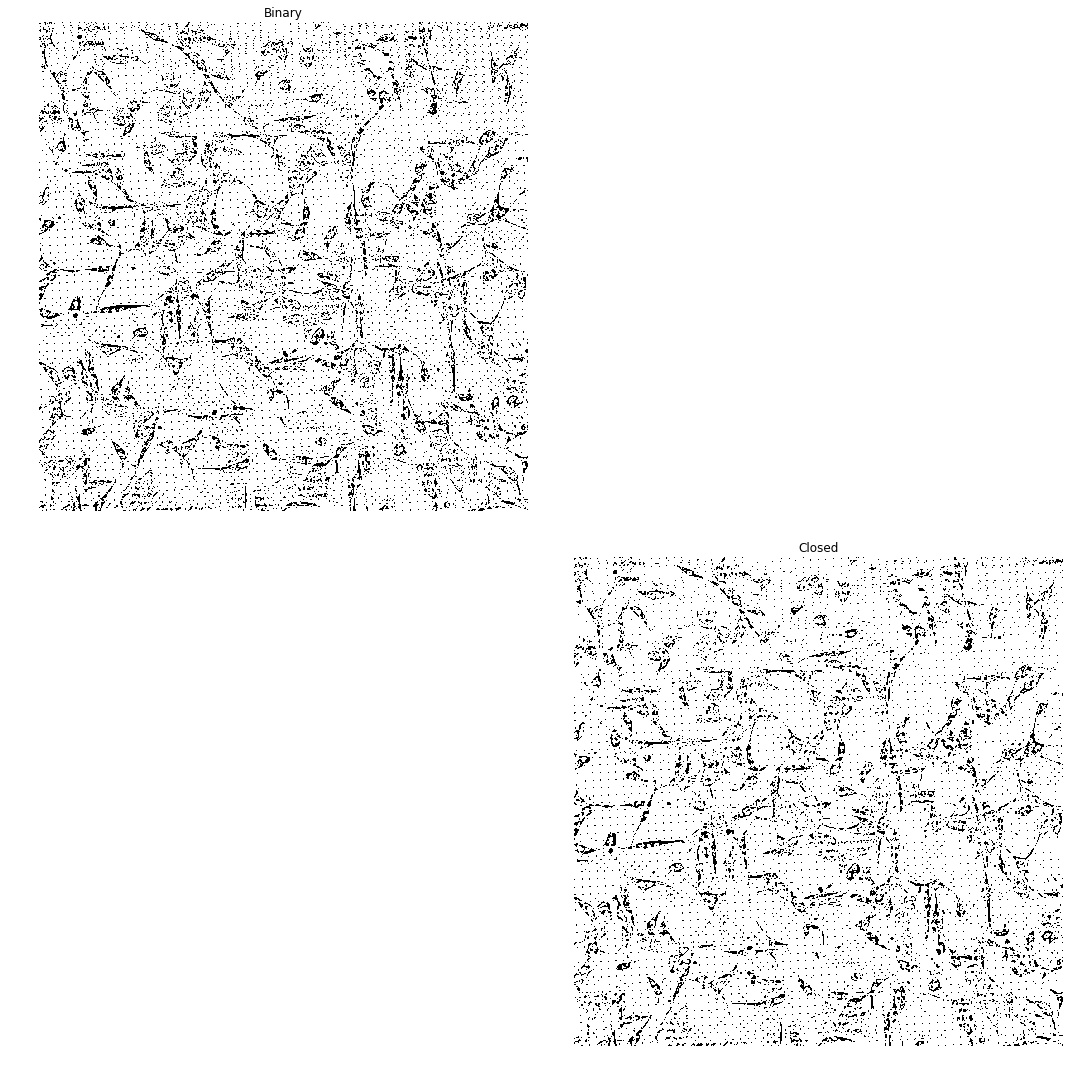

In [8]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
#fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((15,15))).astype('uint8')

#remove_posts = morphology.remove_small_objects(binary, 85)
#remove_posts = morphology.remove_small_holes(remove_posts, 85)
#remove_posts = remove_posts.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
#ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
#ax[1].set_title('Fill Holes')
#ax[2].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
#ax[2].set_title('Removed posts')
ax[3].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#plt.savefig("2_thresh_close.jpg")

In [9]:
binary=np.invert(binary)

#### Sure foreground / background determination

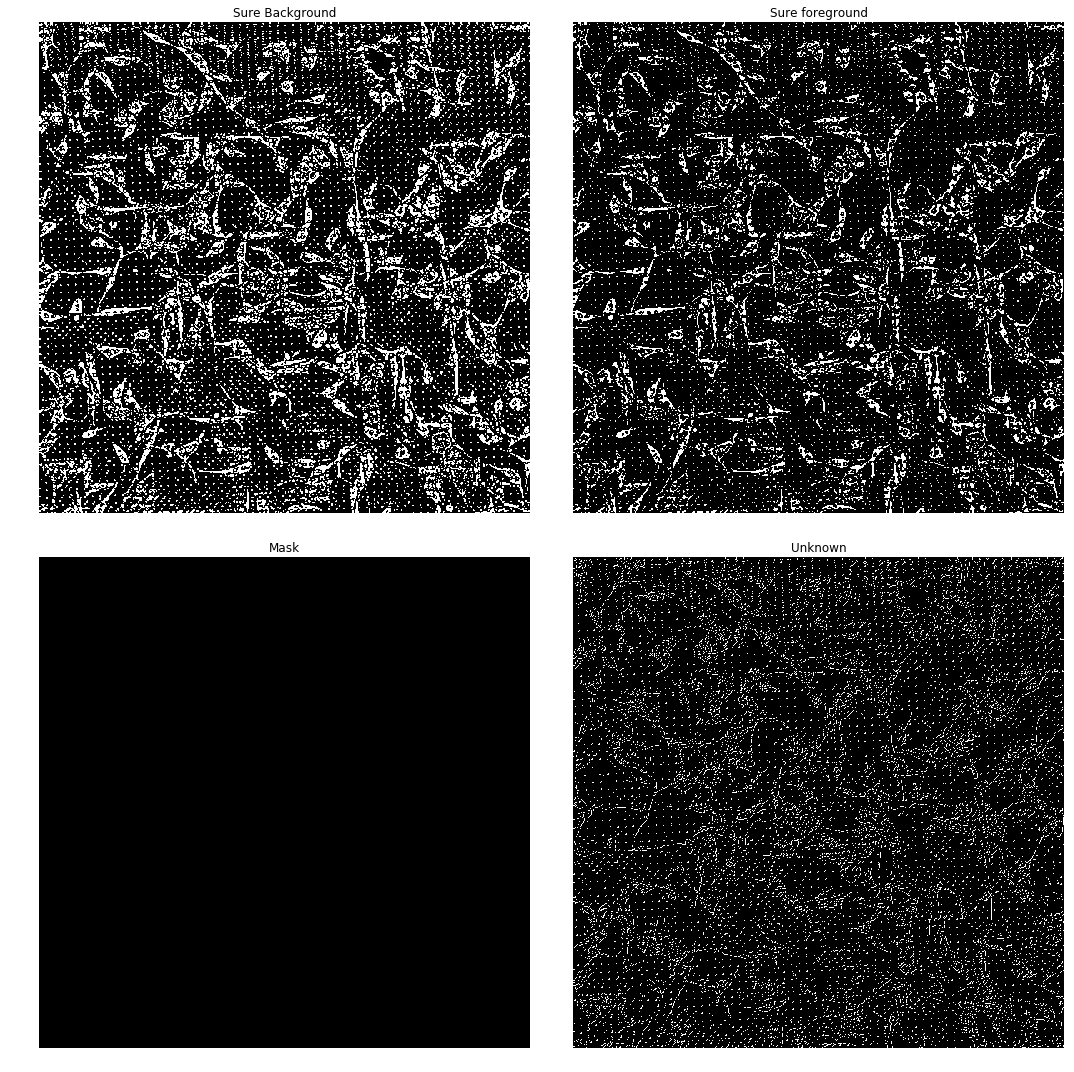

In [10]:
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 2)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = cv2.dilate(closing,kernel,iterations=1)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Label markers

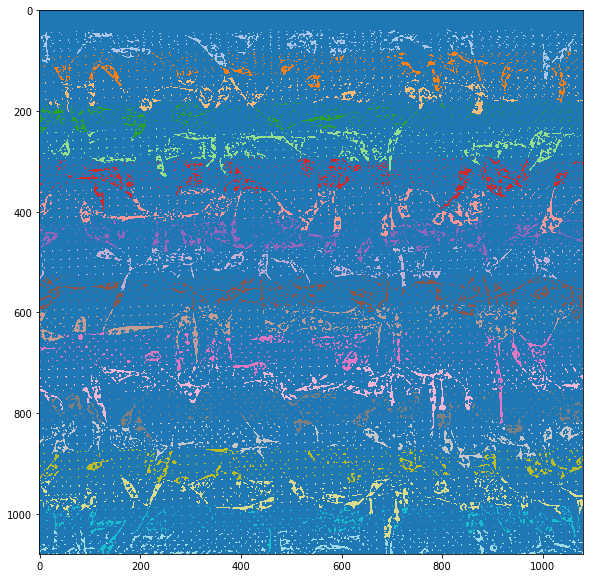

In [11]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown>0] = 0

fig = plt.figure(figsize=(15,10))
plt.imshow(markers, cmap=plt.cm.tab20)

#### Run the watershed algorithm

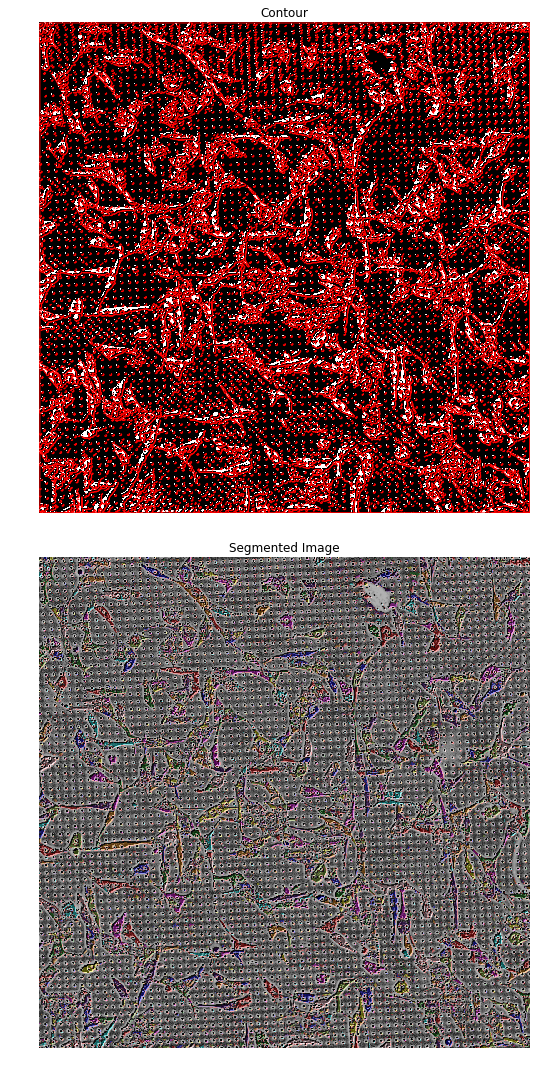

In [12]:
threeChannels = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image, bg_label=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].contour(segmented, [0.5], linewidths=1, colors='r')
ax[0].set_title('Contour')
ax[1].imshow(image_label_overlay)
ax[1].set_title('Segmented Image')

for a in ax:
    a.set_axis_off()

    
plt.tight_layout()
plt.show()

In [13]:
reg = regionprops(segmented, intensity_image=image)[1:]
cellreg = [region for region in reg if (region.area) > 100 and (region.area) < 25000]

#### Extract the region properties

Note that label 1 is attributed to the background in the code above

In [14]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg])
df.head(5)

Label   Area  Eccentricity  Circularity  Bbox Area                 Bbox  \
0   26.0  145.0      0.894336     0.280046  1166400.0    (1, 841, 27, 855)   
1   71.0  308.0      0.975395     0.132979  1166400.0  (5, 1028, 21, 1079)   
2  127.0  115.0      0.973943     0.236845  1166400.0   (10, 122, 20, 152)   
3  166.0  111.0      0.956810     0.233964  1166400.0   (12, 861, 43, 872)   
4  192.0  378.0      0.986199     0.154455  1166400.0   (17, 228, 49, 287)   

                                   Centroid  \
0    (15.76551724137931, 847.1862068965518)   
1  (11.529220779220779, 1054.5811688311687)   
2  (14.756521739130434, 137.47826086956522)   
3     (25.74774774774775, 866.063063063063)   
4    (34.01322751322751, 255.8095238095238)   

                                               Image  Long Axis  Short Axis  
0  [[37, 15, 79, 203, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  29.631774   13.257114  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  55.134999   12.155373  
2  [[0, 0, 0, 0, 76, 20, 0, 0, 0, 0, 0, 0, 0, 0, ...  34.409631    7.803812  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 213], [0, 0, ...  33.148806    9.636790  
4  [[14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  66.742311   11.050255

#### Display labeled region bounding boxes and labels

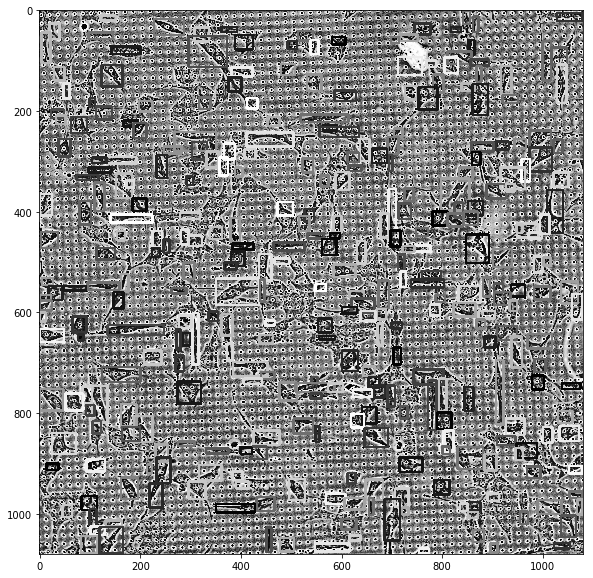

In [15]:
boxed_regions = image.copy()

# Iterate over all non-background labels
for region in cellreg:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    #cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

(205.0, 237.07668711656441, 237.07668711656441)

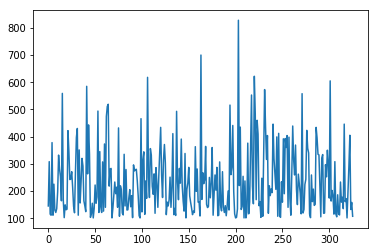

In [16]:
df['Area'].plot()
df['Area'].median(), df['Area'].mean(), df['Area'].mean()

326 cells were detected and segmented
177 cells with selected criteria


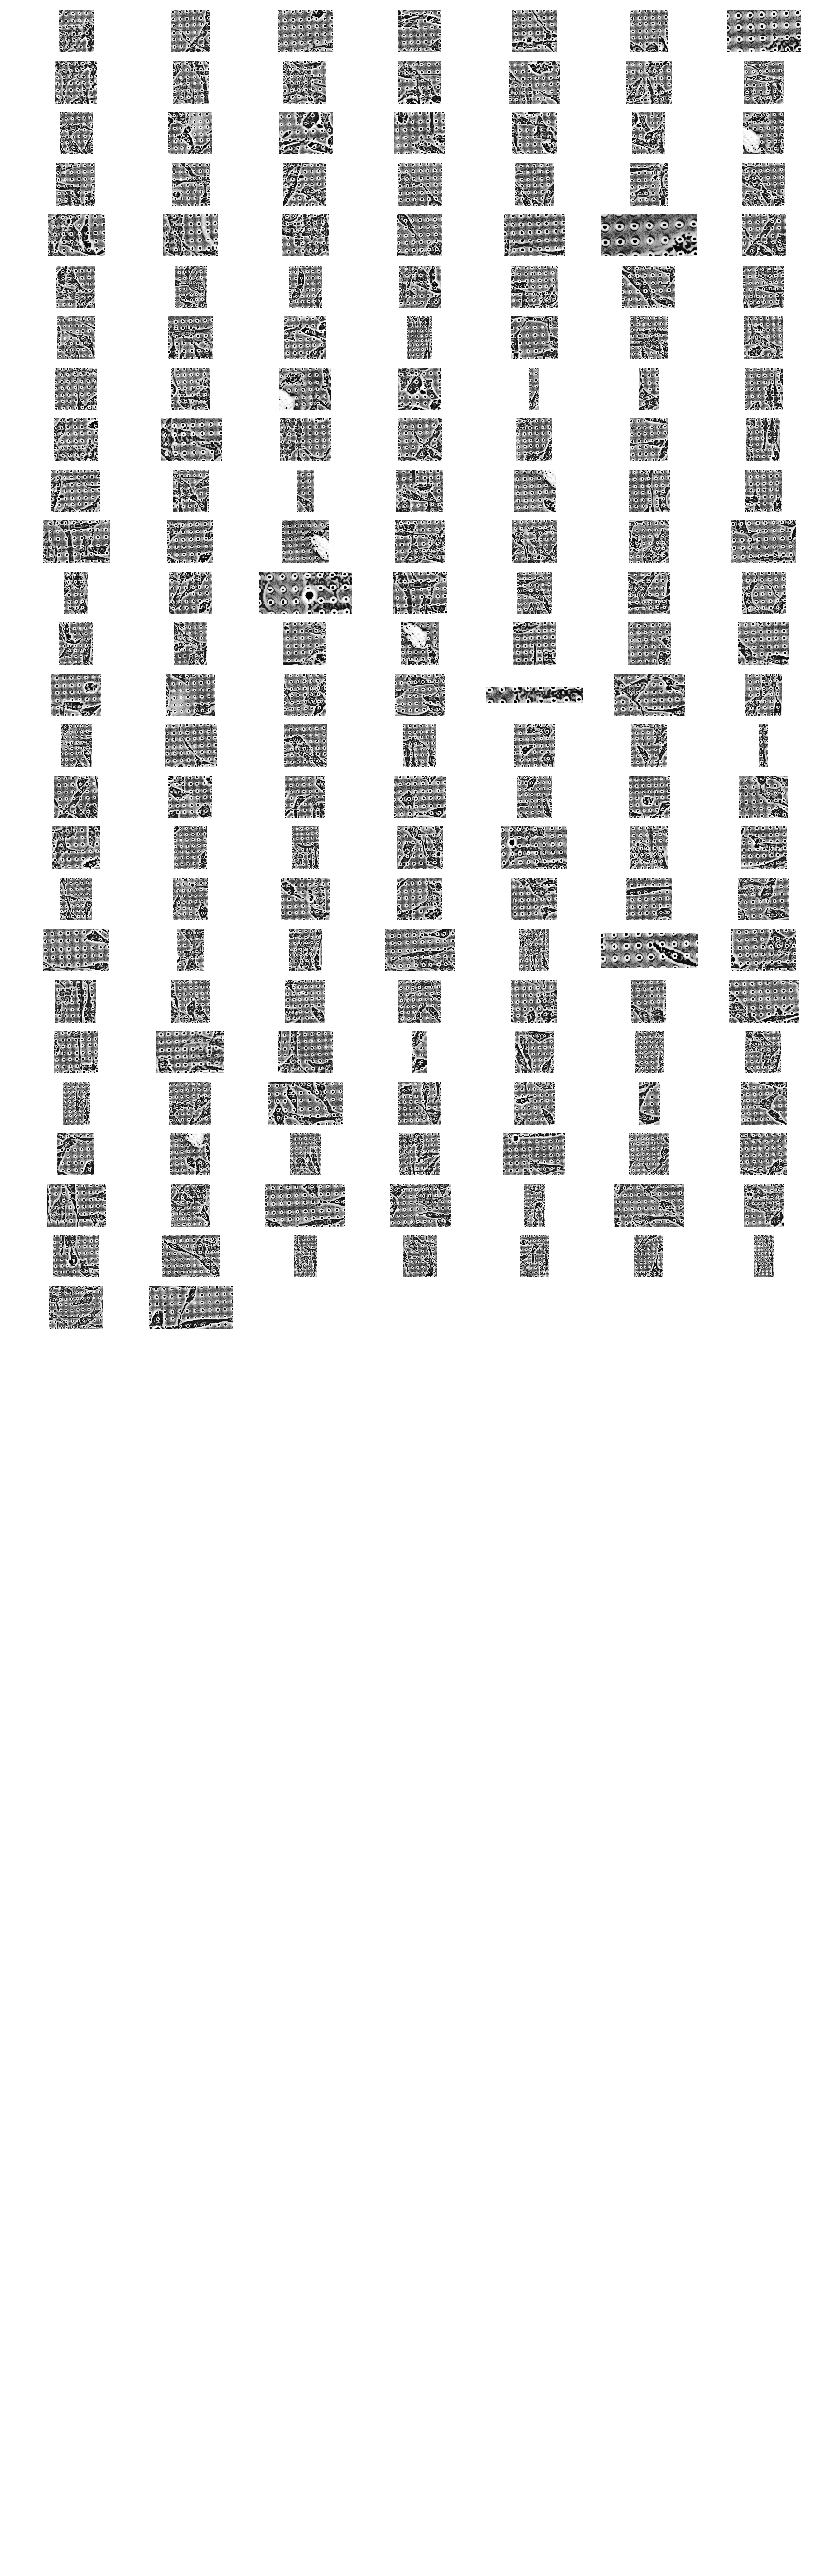

In [17]:
# Display parameters
org_img = image # Intensity image
border = 75 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.05 # circularity cuttoff, removes background circles
ecc_cutoff_upper = 1
area_cutoff_upper = 5*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 0.9*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(cellreg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

cellreg.sort(key=lambda x: x.area)
cellreg_clean = [region for region in cellreg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff and region.eccentricity < ecc_cutoff_upper]

print("{} cells with selected criteria".format(len(cellreg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(cellreg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    name = os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '_cell_' + str(i) + '.jpg')
    imsave(name, contrast_stretch, check_contrast=False)
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(cellreg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)

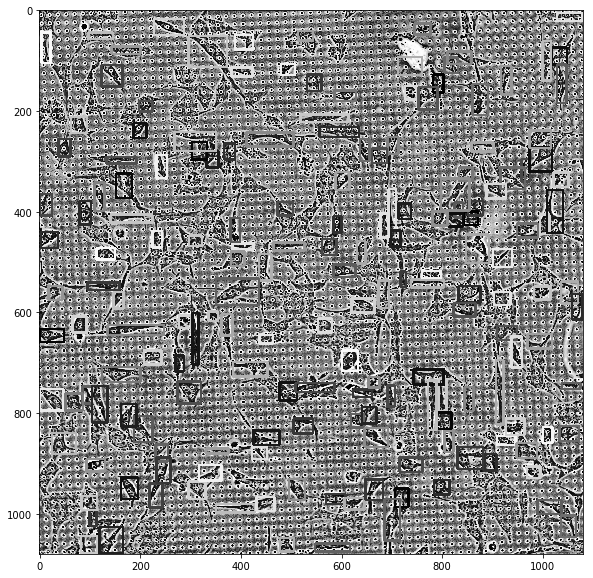

In [18]:
boxed_regions = image.copy()
for region in cellreg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    #cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

In [19]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in cellreg_clean])
df2.tail(5)

Label   Area  Eccentricity  Circularity  Bbox Area  \
172  7623.0  605.0      0.970034     0.095094  1166400.0   
173  3052.0  618.0      0.937538     0.100864  1166400.0   
174  5542.0  622.0      0.997809     0.080945  1166400.0   
175  4328.0  700.0      0.960680     0.054361  1166400.0   
176  5023.0  828.0      0.993629     0.100919  1166400.0   

                       Bbox                                 Centroid  \
172   (970, 685, 1053, 716)  (1015.0925619834711, 700.1768595041323)   
173  (357, 1008, 442, 1040)  (409.8074433656958, 1020.6407766990292)   
174    (694, 907, 822, 922)   (757.2234726688102, 915.5096463022508)   
175    (533, 351, 585, 436)              (558.0785714285714, 392.21)   
176    (625, 136, 645, 248)  (633.3405797101449, 183.04347826086956)   

                                                 Image   Long Axis  Short Axis  
172  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   87.624718   21.290013  
173  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 34, 208,...   78.809806   27.416492  
174  [[0, 0, 0, 33, 214, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  140.959560    9.325519  
175  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   93.900045   26.072208  
176  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  118.232760   13.324553

In [20]:
areaum5 = df2['Area'] / 1.5503 ** 2
areaum5.mean(), areaum5.std()

(134.33954561777557, 46.511131367953595)

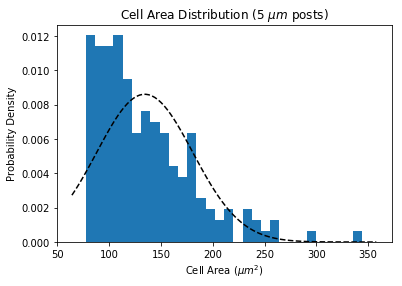

In [21]:
num_bins = 30
mu = areaum5.mean()
std = areaum5.std()
fig, ax = plt.subplots()
plt.hist(areaum5, num_bins, density = 1)

mu, std = norm.fit(areaum5)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, '--', color = 'black')
plt.xlabel("Cell Area ($\mu m^2$)")
plt.ylabel("Probability Density")
plt.title("Cell Area Distribution (5 $\mu m$ posts)")
plt.show ()

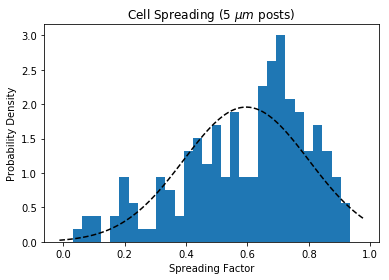

In [22]:
spreading_factor5 = 1 - (df2['Short Axis'] / df2['Long Axis'])

num_bins = 30
muS = spreading_factor5.mean()
stdS = spreading_factor5.std()
fig, ax = plt.subplots()
plt.hist(spreading_factor5, num_bins, density = 1)

muS, stdS = norm.fit(spreading_factor5)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, muS, stdS)

plt.plot(x, p, '--', color = 'black')
plt.xlabel("Spreading Factor")
plt.ylabel("Probability Density")
plt.title("Cell Spreading (5 $\mu m$ posts)")
plt.show ()

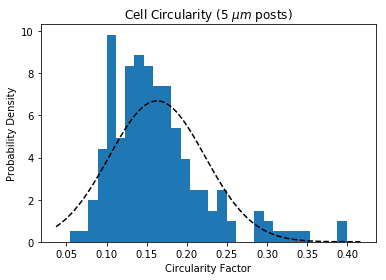

In [23]:
circularity5=df2['Circularity']

num_bins = 30
muC = circularity5.mean()
stdC = circularity5.std()
fig, ax = plt.subplots()
plt.hist(circularity5, num_bins, density = 1)

muC, stdC = norm.fit(circularity5)
xmin, xmax = plt.xlim()
xC = np.linspace(xmin, xmax, 100)
pC = norm.pdf(xC, muC, stdC)

plt.plot(xC, pC, '--', color = 'black')
plt.xlabel("Circularity Factor")
plt.ylabel("Probability Density")
plt.title("Cell Circularity (5 $\mu m$ posts)")
plt.show ()

In [24]:
celllength5 = df2['Long Axis'] / 1.5503
cellwidth5 = df2['Short Axis'] / 1.5503

In [25]:
%store areaum5
%store spreading_factor5
%store circularity5
%store celllength5
%store cellwidth5

Stored 'areaum5' (Series)
Stored 'spreading_factor5' (Series)
Stored 'circularity5' (Series)
Stored 'celllength5' (Series)
Stored 'cellwidth5' (Series)


import pickle

img_list = []
area_list = []
for region in cellreg_clean:
        area_list = df['Area'].tolist()
        cellarea = {img_list[i] : area_list[i] for i in range(len(img_list))}
        
with open(os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '.pkl'), 'wb') as f:
    f.write(pickle.dumps(cellarea))